# Projekt 1 - UTA
### Filip Marciniak 148148
### Szymon Pasternak 148146

Sprawozdanie z projektu 1 dotyczącego metody UTA oraz UTA-GMS.

# Przegląd danych
W zbiorze danych dostępnych jest 27 różnych wariantów reprezentujących różne miejsca na składowisko odpadów, różne scenariusze czasowe oraz różne modele finansowania. Poniżej zaprezentowany jest pełny zbiór danych.

In [1]:
import pandas as pd
df = pd.read_csv("nuclear_dataset.csv", usecols=['C1', 'C2', 'C3', 'C4'])
df

C1    C2    C3    C4
0   0.60  0.93  0.00  0.73
1   0.66  0.55  0.45  0.49
2   1.00  0.45  0.57  0.50
3   0.48  0.87  0.00  0.75
4   0.62  0.40  0.56  0.50
5   0.78  0.27  0.71  0.50
6   0.40  0.90  0.00  0.82
7   0.64  0.44  0.54  0.54
8   0.65  0.30  0.71  0.55
9   0.45  0.86  0.00  0.73
10  0.61  0.54  0.38  0.49
11  0.74  0.25  0.80  0.49
12  0.48  0.97  0.00  0.91
13  0.69  0.49  0.56  0.61
14  0.87  0.03  1.00  0.61
15  0.44  0.95  0.00  0.90
16  0.68  0.40  0.65  0.60
17  0.76  0.06  1.00  0.60
18  0.35  0.91  0.00  0.98
19  0.64  0.22  0.81  0.65
20  0.83  0.25  0.80  0.65
21  0.32  0.83  0.00  0.94
22  0.59  0.24  0.70  0.63
23  0.73  0.03  1.00  0.63
24  0.34  1.00  1.00  1.00
25  0.71  0.25  0.88  0.67
26  0.80  0.06  1.00  0.67

# Informacje preferencyjne

W ramach informacji preferencyjnych należy ocenić parami warianty biorąc pod uwagę czynniki:
- W skutek wyczerpywania się złóż materiałów radioaktywnych, elektrownie mogą zacząć korzystać z bardziej ubogich złóż, co przełoży się na zwiększenie ilości odpadów radioaktywnych
- Inflacja może znacząco wzrosnąć w przyszłości, więc minimalizacja kosztów w przyszłości powinny być ważniejsza niż koszty aktualne

Zdecydowaliśmy się na ocenę par wariantów:
- 0 i 15 (obowiązkowy)
- 10 i 17 (obowiązkowy)
- 18 i 19
- 21 i 19
- 19 i 16

Wybrane porównania parami i przekształcenie na ograniczenia użyteczności:

Wariant 0 > Wariant 15 - $ U(w_0) > U(w_{15}) $ - (wariant 0 jest lepszy równy na kryteriach C2 i C3 od wariantu 15)

Wariant 10 > Wariant 17 - $ U(w_{10}) > U(w_{17}) $ - (wariant 17 ma ocenę 1.00 na kryterium C3, a taki nie może być lepszy od wariantu z przeciętnymi ocenami jakim jest wariant 10)

Wariant 18 > Wariant 19 - $ U(w_{18}) > U(w_{19}) $ - (wariant 18 ma wartość 0 na kryterium C3 więc jest lepszy niż 19)

Wariant 21 > Wariant 19 - $ U(w_{21}) > U(w_{19}) $ - (wariant 21 podobnie jak 18 ma wartość 0 na kryterium C3 więc jest lepszy niż 19, mimo tego że 19 jest lepsze od 21 na kryterium C2)

Wariant 19 > Wariant 16 - $ U(w_{19}) > U(w_{16}) $ - (mimo tego, że wariant 19 jest gorszy od 21 i 18, to nie chcemy, żeby znalazł się wśród najgorszych, ponieważ ma dość niską ocenę na kryterium C2 w porównaniu do przeciętnego wariantu 16. Dlatego wariant 19 jest lepszy od 16.)

In [2]:
# W zmiennej PREFERENCES przechowywane są ustalone preferencje
PREFERENCES = [
    [0, 15],  # 0 > 15
    [10, 17],  # 10 > 17
    [18, 19],  # 18 > 19
    [21, 19],  # 21 > 19
    [19, 16],  # 19 > 16
]

# UTA
Celem zadania 1 jest utworzenie rankingu przy pomocy metody UTA. Kolejne ograniczenia dla problemu programowania matematycznego opisane są w kodzie programu.

In [3]:
# Import biblioteki pulp, dzięki której możliwe jest zamodelowanie problemu programowania matematycznego
from pulp import *

W poniższej komórce kodu następuje zamodelowanie problemu programowania matematycznego. Po rozwiązaniu problemu otrzymujemy wyniki w linijkach
```
problem.solve(solver=GLPK(msg=False))
solution = {variable.name: variable.varValue for variable in problem.variables()}
```
Następnie używamy wyniki do dalszej analizy

In [4]:
# Utworzenie problemu UTA-GMS
problem = LpProblem("uta-gms", LpMaximize)

# Utworzenie zmiennej maksymalizowanej
epsilon = LpVariable("epsilon")

# Utworzenie zmiennych decyzyjnych dla każdego kryterium w problemie programowania matematycznego
decision_variables = {}
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]

# Dodanie ograniczenia na normalizację (maksymalna użyteczność globalna równa 1)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o minimalnych wartościach jest najlepszy
problem += lpSum([x[0] for x in decision_variables.values()]) == 1

# Dodanie ograniczenia na normalizację (minimalna użyteczność globalna równa 0)
# Ponieważ wszystkie kryteria są typu koszt, możemy założyć, że wariant o maksymalnych wartościach jest najgorszy
problem += lpSum([x[-1] for x in decision_variables.values()]) == 0

# Dodanie ograniczeń na monotoniczność funkcji cząstkowych
# W problemie używana jest funkcja ogólna, więc nie ma potrzeby wyliczania interpolacji liniowej
# Wystarczy dodać ograniczenia, które gwarantują, że kolejne zmienne decyzyjne mają nierosnące wartości użyteczności
for column in df.columns:
    for i in range(len(decision_variables[column])-1):
        problem += decision_variables[column][i] >= decision_variables[column][i+1]

# Dodanie ograniczeń związanych z preferencjami decydenta
for preference in PREFERENCES:
    alt_1 = df.loc[preference[0]].to_dict()
    alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        
    alt_2 = df.loc[preference[1]].to_dict()
    alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]

    problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon

problem += epsilon
problem.solve(solver=GLPK(msg=False))
solution = {variable.name: variable.varValue for variable in problem.variables()}

# Wykresy użyteczności

W poniższych komórkach rysujemy przebiegi cząstkowych funkcji użyteczności. Można zauważyć, że wpływ na użyteczność globalną danego wariantu mają kryteria C1, C2 oraz C3. Kryterium C4 zostało wyzerowane. Nagłe spadki w przebiegach kryteriów spowodowane są użyciem funkcji ogólnej oraz małą liczbą podanych preferencji.

In [5]:
import matplotlib.pyplot as plt

In [6]:
utilities = {criterion: [] for criterion in df.columns}
for k, v in solution.items():
    if k.startswith("x_"):
        criterion = k.split("_")[1]
        x = float(k.split("_")[2])
        y = v
        utilities[criterion].append((x, y))

num_plots = len(utilities)
cols = 2
rows = num_plots // cols
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, (k, v) in enumerate(utilities.items()):
    x = [point[0] for point in v]
    y = [point[1] for point in v]
    row = i // cols
    col = i % cols
    ax = axs[row, col]
    
    ax.plot(x, y)
    ax.set_title(k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Wartości użyteczności oraz ranking wszystkich wariantów

W poniższej tabeli zaprezentowane zostały wartości użyteczności globalnych (kolumna `U`) dla wszystkich wariantów, obliczone na podstawie uzyskanych cząstkowych funkcji użyteczności. W kolumnie `rank` wyświetlono ranking dla wariantów, a całą tabelę posortowano właśnie według tej kolumny. Można zauważyć, że istnieją jedynie 3 unikalne wartości użyteczności. Preferencje użytkownika są zachowane.

Wariant 0 > Wariant 15 - Rank 1 > Rank 7

Wariant 10 > Wariant 17 - Rank 7 > Rank 14

Wariant 18 > Wariant 19 - Rank 1 > 7

Wariant 21 > Wariant 19 - Rank 1 > Rank 7

Wariant 19 > Wariant 16 - Rank 7 > Rank 14

Można zauważyć, że warianty, które mają ocenę 0 na kryterium C3 osiągają najlepsze wyniki. Dzieje się tak dlatego, że tylko dla takiego wyniku ta funkcja cząstkowa przyjmuje wartość niezerową.

Do dalszej analizy zbioru danych użyta zostanie metoda $UTA^{GMS}$.

In [7]:
global_utilities = []
for k, alternative in df.iterrows():
    s = 0
    for column in df.columns:
        s += next((point[1] for point in utilities[column] if point[0] == alternative[column]), None)
    global_utilities.append(s)

df_u = df.copy()
df_u['U'] = global_utilities
df_u['rank'] = df_u['U'].rank(ascending=False, method='min')
df_u.sort_values(by='rank')

C1    C2    C3    C4         U  rank
0   0.60  0.93  0.00  0.73  0.999999   1.0
18  0.35  0.91  0.00  0.98  0.999999   1.0
9   0.45  0.86  0.00  0.73  0.999999   1.0
6   0.40  0.90  0.00  0.82  0.999999   1.0
21  0.32  0.83  0.00  0.94  0.999999   1.0
3   0.48  0.87  0.00  0.75  0.999999   1.0
22  0.59  0.24  0.70  0.63  0.666666   7.0
7   0.64  0.44  0.54  0.54  0.666666   7.0
15  0.44  0.95  0.00  0.90  0.666666   7.0
10  0.61  0.54  0.38  0.49  0.666666   7.0
12  0.48  0.97  0.00  0.91  0.666666   7.0
19  0.64  0.22  0.81  0.65  0.666666   7.0
4   0.62  0.40  0.56  0.50  0.666666   7.0
23  0.73  0.03  1.00  0.63  0.333333  14.0
20  0.83  0.25  0.80  0.65  0.333333  14.0
24  0.34  1.00  1.00  1.00  0.333333  14.0
17  0.76  0.06  1.00  0.60  0.333333  14.0
13  0.69  0.49  0.56  0.61  0.333333  14.0
14  0.87  0.03  1.00  0.61  0.333333  14.0
25  0.71  0.25  0.88  0.67  0.333333  14.0
11  0.74  0.25  0.80  0.49  0.333333  14.0
8   0.65  0.30  0.71  0.55  0.333333  14.0
5   0.78  0.27  0.71  0.50  0.333333  14.0
2   1.00  0.45  0.57  0.50  0.333333  14.0
1   0.66  0.55  0.45  0.49  0.333333  14.0
16  0.68  0.40  0.65  0.60  0.333333  14.0
26  0.80  0.06  1.00  0.67  0.333333  14.0

# Wartość funkcji celu

Wartość funkcji celu, czyli epsilon, jest większy od 0. Oznacza to, że solver rozwiązał zadany problem programowania matematycznego.

In [8]:
solution['epsilon']

0.333333

# Analiza możliwych i koniecznych relacji preferencji za pomocą metody UTA-GMS

W ramach zadania 2 należy dla każdej pary wariantów przeprowadzić badanie:

1. Czy istnieje między nimi konieczna relacja preferencji
2. Jeżeli relacja konieczna nie zachodzi, to czy istnieje relacje możliwa

Po uzyskaniu wyników możliwe będzie wyświetlenie diagramu przewyższania.

Budowanie problemu programowania matematycznego odbywa się na podobnej zasadzie co w podstawowej metodzie UTA. Jedyną różnicą jest dodanie odpowiedniego ograniczenia badającego relację konieczną i możliwą. Dodanie odpowiednich ograniczeń zostało oznaczone w kodzie programu.

In [9]:
%%time
NECESSARY = 1
POSSIBLE = 2

alternatives = df.index
df_relations = pd.DataFrame(0, index=alternatives, columns=alternatives)
for alt_1_id in alternatives:
    for alt_2_id in alternatives:
        if alt_1_id == alt_2_id:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue

        # Badanie relacji koniecznej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację konieczną
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_2_variables) >= lpSum(alt_1_variables) + epsilon
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value <= 0:
            df_relations.loc[alt_1_id, alt_2_id] = NECESSARY
            continue
        
        # Badanie relacji możliwej alt_1 > alt_2
        problem = LpProblem("uta-gms", LpMaximize)
        epsilon = LpVariable("epsilon")
        decision_variables = {}
        for column in df.columns:
            unique_values = df[column].sort_values().unique()
            decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
        problem += lpSum([x[0] for x in decision_variables.values()]) == 1
        problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
        for column in df.columns:
            for i in range(len(decision_variables[column])-1):
                problem += decision_variables[column][i] >= decision_variables[column][i+1]
        for preference in PREFERENCES:
            alt_1 = df.loc[preference[0]].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[preference[1]].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        # Dodanie preferencji badającej relację możliwą
        alt_1 = df.loc[alt_1_id].to_dict()
        alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
        alt_2 = df.loc[alt_2_id].to_dict()
        alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
        problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables)
        problem += epsilon
        problem.solve(solver=GLPK(msg=False))
        solution = {variable.name: variable.varValue for variable in problem.variables()}
        epsilon_value = solution['epsilon']
        if epsilon_value > 0:
            df_relations.loc[alt_1_id, alt_2_id] = POSSIBLE

CPU times: user 6.5 s, sys: 307 ms, total: 6.8 s
Wall time: 9.11 s


Poniżej przedstawiono w jaki sposób prezentuje się macierz wynikowa.
W komórce `[i][j]` oznaczono jaka jest relacja pomiędzy wariantem `i` oraz wariantem `j`. Możliwe wartości to:
- 0 - brak relacji
- 1 - relacja konieczna
- 2 - relacja możliwa


In [10]:
df_relations

0   1   2   3   4   5   6   7   8   9   ...  17  18  19  20  21  22  23  \
0    1   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
1    2   1   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
2    2   2   1   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
3    2   2   2   1   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
4    2   2   1   2   1   2   2   2   2   2  ...   2   2   2   2   2   2   2   
5    2   2   2   2   2   1   2   2   2   2  ...   2   2   2   2   2   2   2   
6    2   2   2   2   2   2   1   2   2   2  ...   2   2   2   2   2   2   2   
7    2   2   2   2   2   2   2   1   2   2  ...   2   2   2   2   2   2   2   
8    2   2   2   2   2   2   2   2   1   2  ...   2   2   2   2   2   2   2   
9    1   2   2   1   2   2   2   2   2   1  ...   2   2   2   2   2   2   2   
10   2   1   2   2   2   2   2   2   2   2  ...   1   2   2   2   2   2   2   
11   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   1   2   2   2   
12   0   2   2   2   2   2   2   2   2   0  ...   2   2   2   2   2   2   2   
13   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
14   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
15   0   2   2   2   2   2   2   2   2   0  ...   2   2   2   2   2   2   2   
16   2   2   2   2   2   2   2   2   2   2  ...   2   0   0   2   0   2   2   
17   2   2   2   2   2   2   2   2   2   2  ...   1   2   2   2   2   2   2   
18   2   2   2   2   2   2   2   2   2   2  ...   2   1   1   2   2   2   2   
19   2   2   2   2   2   2   2   2   2   2  ...   2   0   1   2   0   2   2   
20   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   1   2   2   2   
21   2   2   2   2   2   2   2   2   2   2  ...   2   1   1   2   1   2   2   
22   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   1   2   1   2   
23   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   1   
24   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
25   2   2   2   2   2   2   2   2   2   2  ...   2   0   2   2   0   2   2   
26   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   

    24  25  26  
0    2   2   2  
1    2   2   2  
2    2   2   2  
3    2   2   2  
4    2   2   2  
5    2   2   2  
6    2   2   2  
7    2   2   2  
8    2   2   2  
9    2   2   2  
10   2   2   1  
11   2   2   2  
12   2   2   2  
13   2   2   2  
14   2   2   2  
15   2   2   2  
16   2   2   2  
17   2   2   1  
18   2   1   2  
19   2   1   2  
20   2   2   2  
21   1   1   2  
22   2   1   2  
23   2   2   1  
24   1   2   2  
25   2   1   2  
26   2   2   1  

[27 rows x 27 columns]

# Diagram Hasse relacji koniecznych

Na obrazku zaprezentowany został diagram Hasse relacji koniecznych. Połączenie od jednego wariantu do drugiego symbolizuje relację konieczną zachodzą pomiędzy nimi. Usunięte zostały łuki, które wynikają z przechodniości relacji. Można zauważyć, że otrzymane zostały 4 poziomy wariantów. Preferencje decydenta zostały zachowane:

Wariant 0 > Wariant 15 - bezpośrednia relacja widoczna na grafie

Wariant 10 > Wariant 17 - bezpośrednia relacja widoczna na grafie

Wariant 18 > Wariant 19 - bezpośrednia relacja widoczna na grafie

Wariant 21 > Wariant 19 - relacja przechodząca przez wariant 18

Wariant 19 > Wariant 16 - bezpośrednia relacja widoczna na grafie

![graph](./graph.svg)

# Reprezentatywna funkcja użyteczności

W ramach zadania 3 należy skonstruować reprezentatywną funkcję użyteczności. Korzysta ona z wyników otrzymanych w metodzie $UTA^{GMS}$. Poniżej przedstawiony został kod programu, który modeluje problem programowania matematycznego. Dodatkowymi ograniczeniami w porównaniu do standardowej metody UTA są ograniczenia wynikające z relacji koniecznych i możliwych. Problem został obliczony w jednym kroku dzięki zastosowaniu w funkcji celu wyrażenia `M*epsilon - delta`, gdzie M to duża liczba - w tym przypadku ustawiona na wartość 100.

In [11]:
problem = LpProblem("uta-gms-rep", LpMaximize)
M = 100
epsilon = LpVariable("epsilon")
delta = LpVariable("delta")
decision_variables = {}
for column in df.columns:
    unique_values = df[column].sort_values().unique()
    decision_variables[column] = [LpVariable(f"x_{column}_{value}", 0, 1) for value in unique_values]
problem += lpSum([x[0] for x in decision_variables.values()]) == 1
problem += lpSum([x[-1] for x in decision_variables.values()]) == 0
for column in df.columns:
    for i in range(len(decision_variables[column])-1):
        problem += decision_variables[column][i] >= decision_variables[column][i+1]
for preference in PREFERENCES:
    alt_1 = df.loc[preference[0]].to_dict()
    alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
    alt_2 = df.loc[preference[1]].to_dict()
    alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
    problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon

# Dodanie preferencji wynikających z relacji koniecznych i możliwych
for alt_1_id in df_relations.index:
    for alt_2_id in df_relations.columns:
        if alt_1_id == alt_2_id:
            continue
        relation = df_relations.loc[alt_1_id, alt_2_id]
        if relation == NECESSARY:
            alt_1 = df.loc[alt_1_id].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[alt_2_id].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) >= lpSum(alt_2_variables) + epsilon
        else:
            alt_1 = df.loc[alt_1_id].to_dict()
            alt_1_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v in alt_1.items()]
            alt_2 = df.loc[alt_2_id].to_dict()
            alt_2_variables = [next((variable for variable in decision_variables[k] if str(variable) == f"x_{k}_{v}"), None) for k, v, in alt_2.items()]
            problem += lpSum(alt_1_variables) - lpSum(alt_2_variables) <= delta

problem += M*epsilon-delta
problem.solve(solver=GLPK(msg=False))
solution = {variable.name: variable.varValue for variable in problem.variables()}
epsilon_value = solution['epsilon']
delta_value = solution['delta']

Wartości epsilon oraz delta są większe od 0, co oznacza że możemy odczytać rozwiązanie.

In [12]:
epsilon_value, delta_value

(0.166667, 0.666667)

Przebiegi cząstkowych funkcji wartości różnią się od tych uzyskanych przy pomocy podstawowej metody UTA. Można zaobserwować, że tym razem kryterium C3 również zostało wyzerowane, a kryterium C1 przyjmuje więcej różnych wartości niż jedynie dwie. Spowodowane jest to większą liczbą ograniczeń wprowadzonych do problemu, które wynikają z relacji uzyskanych metodą $UTA^{GMS}$.

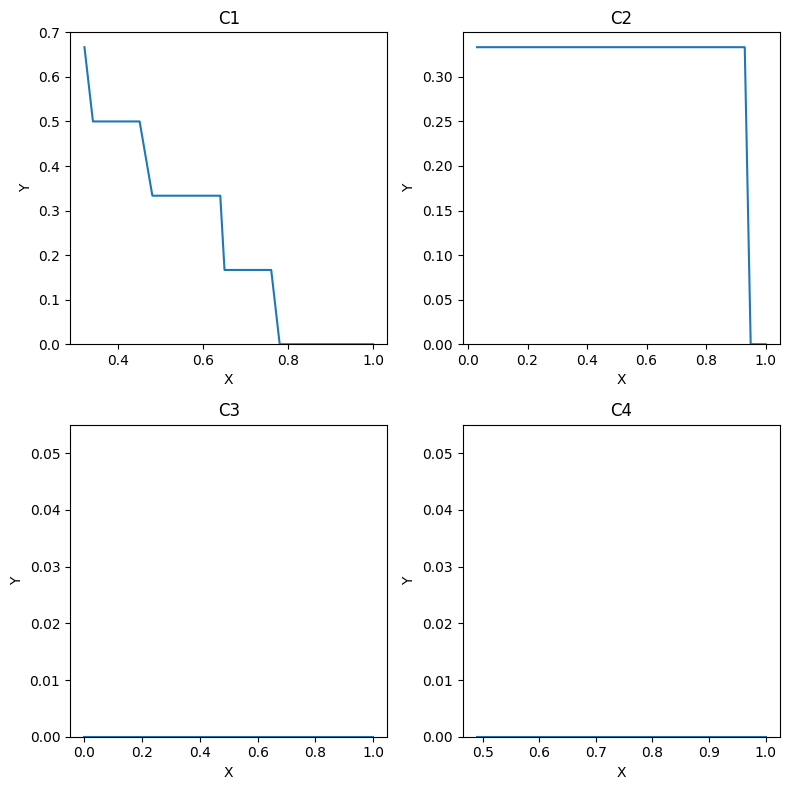

In [13]:
utilities = {criterion: [] for criterion in df.columns}
for k, v in solution.items():
    if k.startswith("x_"):
        criterion = k.split("_")[1]
        x = float(k.split("_")[2])
        y = v
        utilities[criterion].append((x, y))

num_plots = len(utilities)
cols = 2
rows = num_plots // cols
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, (k, v) in enumerate(utilities.items()):
    x = [point[0] for point in v]
    y = [point[1] for point in v]
    row = i // cols
    col = i % cols
    ax = axs[row, col]
    
    ax.plot(x, y)
    ax.set_title(k)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

Poniżej zaprezentowano tabelę z wynikami użyteczności globalnych oraz ranking w takiej samej formie jak poprzednio. Wartości globalnych użyteczności są teraz bardziej zróżnicowane, co jest skutkiem dodania dodatkowych ograniczeń do problemu. Najlepszym wariantem okazał się być wariant 21, który w podstawowej metodzie UTA również otrzymał `rank 1`. Preferencje decydenta nadal są zachowane w rankingu wynikowym.

In [14]:
global_utilities = []
for k, alternative in df.iterrows():
    s = 0
    for column in df.columns:
        s += next((point[1] for point in utilities[column] if point[0] == alternative[column]), None)
    global_utilities.append(s)

df_u = df.copy()
df_u['U'] = global_utilities
df_u['rank'] = df_u['U'].rank(ascending=False, method='min')
df_u.sort_values(by='rank')

C1    C2    C3    C4         U  rank
21  0.32  0.83  0.00  0.94  1.000000   1.0
6   0.40  0.90  0.00  0.82  0.833333   2.0
9   0.45  0.86  0.00  0.73  0.833333   2.0
18  0.35  0.91  0.00  0.98  0.833333   2.0
0   0.60  0.93  0.00  0.73  0.666666   5.0
3   0.48  0.87  0.00  0.75  0.666666   5.0
4   0.62  0.40  0.56  0.50  0.666666   5.0
22  0.59  0.24  0.70  0.63  0.666666   5.0
7   0.64  0.44  0.54  0.54  0.666666   5.0
10  0.61  0.54  0.38  0.49  0.666666   5.0
19  0.64  0.22  0.81  0.65  0.666666   5.0
24  0.34  1.00  1.00  1.00  0.500000  12.0
23  0.73  0.03  1.00  0.63  0.500000  12.0
17  0.76  0.06  1.00  0.60  0.500000  12.0
16  0.68  0.40  0.65  0.60  0.500000  12.0
13  0.69  0.49  0.56  0.61  0.500000  12.0
25  0.71  0.25  0.88  0.67  0.500000  12.0
11  0.74  0.25  0.80  0.49  0.500000  12.0
8   0.65  0.30  0.71  0.55  0.500000  12.0
1   0.66  0.55  0.45  0.49  0.500000  12.0
15  0.44  0.95  0.00  0.90  0.500000  12.0
14  0.87  0.03  1.00  0.61  0.333333  22.0
12  0.48  0.97  0.00  0.91  0.333333  22.0
20  0.83  0.25  0.80  0.65  0.333333  22.0
5   0.78  0.27  0.71  0.50  0.333333  22.0
2   1.00  0.45  0.57  0.50  0.333333  22.0
26  0.80  0.06  1.00  0.67  0.333333  22.0

# Wnioski

W ramach projektu przeprowadzono badania na zbiorze danych "Nuclear waste management" przy użyciu metod UTA oraz UTA-GMS. Badania wykazały, że:

1. Metoda UTA wraz z użyciem funkcji ogólnej użyteczności cząstkowej bardzo łatwo potrafi dopasować się do preferencji decydenta. Dla omawianego problemu istotne i brane pod uwagę w wyliczaniu rankingu w etapie agregracji są trzy kryteria - C1, C2 i C3, a kryterium C4 zostało wyzerowane, co może być spowodowane brakiem ograniczeń na wagi kryteriów. Wynik podzielił cały zbiór danych jedynie na różne 3 rangi.

2. W wyniku działania metody UTA-GMS pozyskane zostały relacje konieczne i możliwe przedstawione przy pomocy diagramu Hasse. Można zaobserwować, że zbiór danych został podzielony na 4 rangi, natomiast trudno powiedzieć na podstawie grafu, który z wariantów jest faktycznie najlepszy.

3. Funkcja reprezentatywna otrzymana przy pomocy relacji koniecznych i możliwych uzyskanych z metody UTA-GMS dostarczyła bardziej zróżnicowanych wyników. Jest to spowodowane większą liczbą ograniczeń dodanych do problemu programowania matematycznego. Warianty uzyskują użyteczności ze zbioru 5 różnych wartości. Najlepszy okazał się wariant 21. Jest to spowodowane dostarczonymi do metody preferencjami. Wariant 21 jest lepszy od wariantu 19, który z kolei jest lepszy od wariantu 16. Powoduje to, że wariant 21 jest mocno premiowany.

Dalsze badania mogłyby obejmować zastosowanie większej ilości porównań parami, wprowadzenie porównań reprezentujących nierozróżnialność pomiędzy wariantami, czy też rozszerzenia takie jak GRIP lub możliwe pozycje najlepsze/najgorsze dla danego wariantu. W ramach dalszej analizy można byłoby również skorzystać z samplera, który dostarczyłby informacje na temat stochastycznej analizy regresji porządkowej i indeksów akceptowalności dla wariantów.